In [6]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# General Utilities
import math
import json
import pprint
import itertools
import importlib

# Some settings
from IPython.display import Markdown, display
log = pprint.pprint
space = lambda: print()
printmd = lambda text: display(Markdown(text))
%matplotlib inline

def set_pandas_display_options() -> None:
    """Set pandas display options."""
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

set_pandas_display_options()

In [7]:
non_insight = ['What day follows the day before yesterday if two days from now will be Sunday?',
'Ben spent $42 for shoes. This was $14 less than what he spent for a shirt and twice more expensive than the tie. The tie was $20 cheaper than the jeans. How much was the jeans?',
'Next week I am going to have lunch with my friend, visit the new art gallery, go to the Social Security office, and have my teeth checked at the dentist. My friend cannot meet me on Wednesday; the Social Security office is closed weekends; the dentist has office hours only on Tuesday, Friday, and Saturday; the art gallery is closed Tuesday, Thursday, and weekends. On what single day can I do everything I have planned?',
'A group of soldiers were standing facing west. Their sergeant shouted at them: Right turn! U-turn! Left turn! U-turn! Right turn! U-turn! Left turn! Right turn! In which direction are they now facing?',
'The following verse spells out a word. I am a food for you and me. My first letter is in pat but not in tar. My second letter is in stream but not in smart. My third letter is in giraffe but not in fridge. My fourth letter is in treat but not in absent. What is the word that this verse described?'];
 
anagram = ['Solve this anagram: NCRBOA', 
						'Solve this anagram: AYKAWLJ', 
						'Solve this anagram: EVANG',
						'Solve this anagram: MARNOD',
						'Solve this anagram: AALRYS']

In [8]:
with open('pilot3.json') as json_file:
    data = json.load(json_file)  

In [9]:
questions_non_insight = []
answers_non_insight = [] #whether people typed done or skip
solutions_non_insight = []
confidence_non_insight = []
difficulty_non_insight = []
aha_non_insight = []
rts_non_insight = []
close_non_insight = []

questions_insight = []
answers_insight = []
solutions_insight = []
confidence_insight = []
difficulty_insight = []
aha_insight = []
rts_insight = []
close_insight = []

questions_anagram = []
solutions_anagram = []
answers_anagram = []
confidence_anagram = []
difficulty_anagram = []
aha_anagram = []
rts_anagram = []
close_anagram = []

for i in range(len(data)): #go thru the subjects
    if len(data[i]['data']) > 3: #only look at subjects that finished the task (and not just started without finishing)
        if 1 == 1: #'DONE' in data[i]['data'][3]['responses']: #passed attention/quiz check (for now we are considering all subjects)
            
            k = 5
            
            for j in range(2):
                question = data[i]['data'][0]['problems_seen'][j] #store the question seen by the participant
                answers = []
                rt = 0     
                counter = 0
                bad_subject = 0
                close = []
                
                while True:
                    answer = data[i]['data'][k]['responses']
                    if(len(answer) > 9): #Did the subject type a response in the box?
                        counter = counter + 1

                    answers.append(answer)
                    k = k+1
                    close.append(int(data[i]['data'][k]['response']))
                    if 'done' not in answer.lower() and 'skip' not in answer.lower():
                        rt = rt+10
                        k = k+1
                    else:
                        rt = rt + data[i]['data'][k]['rt']/1000
                        k = k+1
                        if counter > 3: #subject has typed a response in the box more than 6 times for the problems-- not reading instruction!
                            bad_subject = 1
                        break
                
                solution = data[i]['data'][k]['responses'] #store people's solution here
                k = k+1
                response = data[i]['data'][k]['responses'] #store people's responses to the judgment questions here
                k = k+2 #move to the next question
                
                if bad_subject == 0 and question in non_insight:   
                    questions_non_insight.append(question)
                    answers_non_insight.append(answers)
                    solutions_non_insight.append(solution)
                    rts_non_insight.append(rt)
                    confidence_non_insight.append(int(response[6])+1)
                    difficulty_non_insight.append(int(response[13])+1)
                    aha_non_insight.append(int(response[20])+1)
                    close_non_insight.append(close)

                elif bad_subject == 0 and question in anagram:
                    questions_anagram.append(question)
                    answers_anagram.append(answers)
                    solutions_anagram.append(solution)
                    rts_anagram.append(rt)
                    confidence_anagram.append(int(response[6])+1)
                    difficulty_anagram.append(int(response[13])+1)
                    aha_anagram.append(int(response[20])+1)
                    close_anagram.append(close)
        else:
            print(data[i]['data'][3]['responses'])
            print('bad subject!')

Convert data into df

In [13]:
d = {'questions':questions_non_insight,
     'answers':answers_non_insight, 
     'solutions': solutions_non_insight,
     'rts': rts_non_insight,
     'confidence': confidence_non_insight, 
     'difficulty': difficulty_non_insight, 
     'aha': aha_non_insight,
     'close': close_non_insight}

d2 = {'questions':questions_anagram,
     'answers':answers_anagram, 
      'solutions': solutions_anagram,
     'rts': rts_anagram,
     'confidence': confidence_anagram, 
     'difficulty': difficulty_anagram, 
     'aha': aha_anagram,
     'close': close_anagram}

df_non_insight = pd.DataFrame(d)
df_anagram = pd.DataFrame(d2)

#Analyze only those responses for which people didn't leave a blank answer (len = 9) and said DONE (not SKIP)
df_non_insight_filtered = df_non_insight.loc[(df_non_insight['confidence'] >= 5) & (df_non_insight['solutions'].str.len() > 9) & 
                                             (df_non_insight['solutions'].str.contains("done", case = False)==False) &
                                             (df_non_insight['close'].str[0] != 100) & (df_non_insight['close'].str.len() > 1)]
#also remove people who solved the anagram before 7 seconds
df_anagram_filtered = df_anagram.loc[(df_anagram['confidence'] >= 5) & (df_anagram['solutions'].str.len() > 9) & 
                                     (df_anagram['solutions'].str.contains("done", case = False)==False) &
                                     (df_anagram['close'].str[0] != 100) & (df_anagram['close'].str.len() > 1)]
#(df_non_insight['answers'].str.contains("done", case=False))

print(len(df_non_insight.index), len(df_non_insight_filtered.index))
print(len(df_anagram.index), len(df_anagram_filtered.index))

97 68
97 39


For the filtered data, get people's prediction error (when they said greater than 95 and last point before that)

In [14]:
tpe_non_insight = []
ahas_non_insight = []
increment_non_insight = []

for i in range(len(df_non_insight_filtered.index)):
    a = df_non_insight_filtered['close'].iloc[i]
    aha = df_non_insight_filtered['aha'].iloc[i]
    increments = []
    for j in range(len(a)):
            
            if j == 0:
                increments.append(a[j] - 0)
            
            elif (a[j] < 95):    
                increments.append(a[j] - a[j-1])
            
            elif(a[j] > 95): #subject gave greater than 90 confidence!
                tpe_non_insight.append(a[j] - a[j-1])
                ahas_non_insight.append(aha)
                increment_non_insight.append(increments)
                break

tpe_anagram = []
ahas_anagram = []
increment_anagram = []

for i in range(len(df_anagram_filtered.index)):
    a = df_anagram_filtered['close'].iloc[i]
    aha = df_anagram_filtered['aha'].iloc[i]
    increments = []
    for j in range(len(a)):
        
            if j == 0:
                increments.append(a[j] - a[j])
            
            elif (a[j] < 95):    
                increments.append(a[j] - a[j-1])
        
            if(a[j] > 95): #subject gave greater than 90 confidence!
                tpe_anagram.append(a[j] - a[j-1])
                ahas_anagram.append(aha)
                increment_anagram.append(increments)
                break
            
print(np.mean(tpe_non_insight))
print(np.mean(ahas_non_insight))

print(np.mean(tpe_anagram))
print(np.mean(ahas_anagram))

#print(np.corrcoef(ahas_non_insight+ahas_anagram, tpe_non_insight+tpe_anagram))
print(np.mean(sum(increment_non_insight, [])))
print(np.mean(sum(increment_anagram, [])))

42.148148148148145
3.0
51.05714285714286
5.542857142857143
10.452702702702704
8.796875


To do -- [check ratio (increment per probe), difference between last rating and 100, and average plot of warmth rating for each problem]

Create separate dfs for each non insight question

In [15]:
df1 = df_non_insight_filtered.loc[(df_non_insight['questions'].str.contains("yesterday", case=False))]
df2 = df_non_insight_filtered.loc[(df_non_insight['questions'].str.contains("giraffe", case=False))]
df3 = df_non_insight_filtered.loc[(df_non_insight['questions'].str.contains("soldiers", case=False))]
df4 = df_non_insight_filtered.loc[(df_non_insight['questions'].str.contains("security", case=False))]
df5 = df_non_insight_filtered.loc[(df_non_insight['questions'].str.contains("cheaper", case=False))]

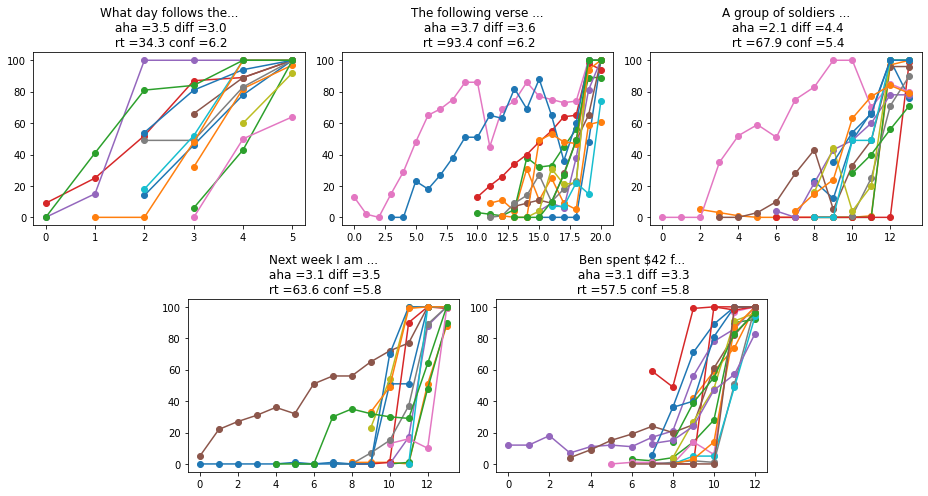

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

fig = plt.figure(figsize=(13, 7))
gs = gridspec.GridSpec(2, 6)

for i in range(0, 5):
    if i < 3:
        ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
    else:
        ax = plt.subplot(gs[1, 2 * i - 11:2 * i + 2 - 11])
    
    if i == 0:
        max_len = max(df1['close'].str.len())
        for j, row in df1.iterrows():
            x = list(range(0, len(row['close'])))
            x2 = [(max_len-len(x))+i for i in x] #align the ends in the plot
            plt.plot(x2, row['close'], '-o')
        plt.title(df1['questions'].iloc[0][0:20]+'...'+'\n aha ='+str(round(df1['aha'].mean(),1))
                 +' diff ='+str(round(df1['difficulty'].mean(),1))+'\n rt ='+str(round(df1['rts'].mean(),1))
                 +' conf ='+str(round(df1['confidence'].mean(),1)))
    elif i == 1:
        max_len = max(df2['close'].str.len())
        for j, row in df2.iterrows():
            x = list(range(0, len(row['close'])))
            x2 = [(max_len-len(x))+i for i in x] #align the ends
            plt.plot(x2, row['close'], '-o')
        plt.title(df2['questions'].iloc[0][0:20]+'...'+'\n aha ='+str(round(df2['aha'].mean(),1))
                 +' diff ='+str(round(df2['difficulty'].mean(),1))+'\n rt ='+str(round(df2['rts'].mean(),1))
                 +' conf ='+str(round(df2['confidence'].mean(),1)))
    elif i == 2:
        max_len = max(df3['close'].str.len())
        for j, row in df3.iterrows():
            x = list(range(0, len(row['close'])))
            x2 = [(max_len-len(x))+i for i in x] #align the ends
            plt.plot(x2, row['close'], '-o')
        plt.title(df3['questions'].iloc[0][0:20]+'...'+'\n aha ='+str(round(df3['aha'].mean(),1))
                 +' diff ='+str(round(df3['difficulty'].mean(),1))+'\n rt ='+str(round(df3['rts'].mean(),1))
                 +' conf ='+str(round(df3['confidence'].mean(),1)))
    elif i == 3:
        max_len = max(df4['close'].str.len())
        for j, row in df4.iterrows():
            x = list(range(0, len(row['close'])))
            x2 = [(max_len-len(x))+i for i in x] #align the ends
            plt.plot(x2, row['close'], '-o')
        plt.title(df4['questions'].iloc[0][0:15]+'...'+'\n aha ='+str(round(df4['aha'].mean(),1))
                 +' diff ='+str(round(df4['difficulty'].mean(),1))+'\n rt ='+str(round(df4['rts'].mean(),1))
                 +' conf ='+str(round(df4['confidence'].mean(),1)))
    elif i == 4:
        max_len = max(df5['close'].str.len())
        for j, row in df5.iterrows():
            x = list(range(0, len(row['close'])))
            x2 = [(max_len-len(x))+i for i in x] #align the ends
            plt.plot(x2, row['close'], '-o')
        plt.title(df5['questions'].iloc[0][0:15]+'...'+'\n aha ='+str(round(df5['aha'].mean(),1))
                 +' diff ='+str(round(df5['difficulty'].mean(),1))+'\n rt ='+str(round(df5['rts'].mean(),1))
                 +' conf ='+str(round(df5['confidence'].mean(),1)))
            
plt.tight_layout()
plt.show()

In [18]:
df6 = df_anagram_filtered.loc[(df_anagram['questions'].str.contains("AALRYS", case=False))]
df7 = df_anagram_filtered.loc[(df_anagram['questions'].str.contains("AYKAWLJ", case=False))]
df8 = df_anagram_filtered.loc[(df_anagram['questions'].str.contains("NCRBOA", case=False))]
df9 = df_anagram_filtered.loc[(df_anagram['questions'].str.contains("MARNOD", case=False))]
df10 = df_anagram_filtered.loc[(df_anagram['questions'].str.contains("EVANG", case=False))]

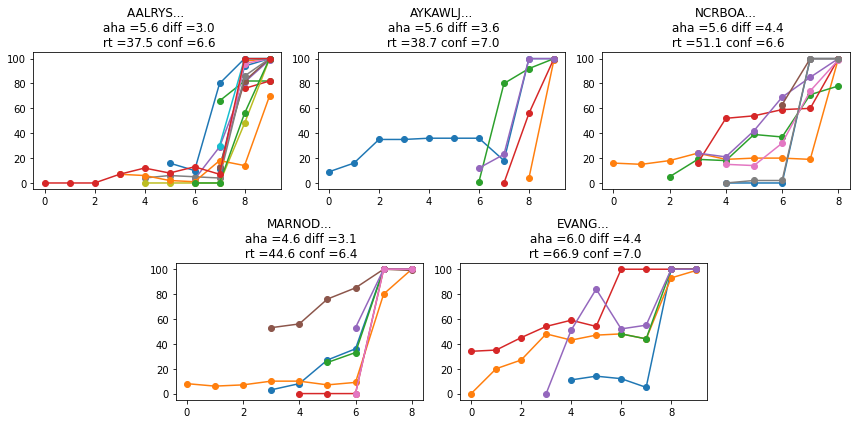

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 6)

for i in range(0, 5):
    if i < 3:
        ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
    else:
        ax = plt.subplot(gs[1, 2 * i - 11:2 * i + 2 - 11])
    
    if i == 0:
        max_len = max(df6['close'].str.len())
        for j, row in df6.iterrows():
            x = list(range(0, len(row['close'])))
            x2 = [(max_len-len(x))+i for i in x] #align the ends in the plot
            plt.plot(x2, row['close'], '-o')
        plt.title(df6['questions'].iloc[0][20:30]+'... \n'+' aha ='+str(round(df6['aha'].mean(),1))
                 +' diff ='+str(round(df6['difficulty'].mean(),1))+'\n rt ='+str(round(df6['rts'].mean(),1))
                 +' conf ='+str(round(df6['confidence'].mean(),1)))
    elif i == 1:
        max_len = max(df7['close'].str.len())
        for j, row in df7.iterrows():
            x = list(range(0, len(row['close'])))
            x2 = [(max_len-len(x))+i for i in x] #align the ends in the plot
            plt.plot(x2, row['close'], '-o')
        plt.title(df7['questions'].iloc[0][20:30]+'...'+'\n aha ='+str(round(df7['aha'].mean(),1))
                 +' diff ='+str(round(df7['difficulty'].mean(),1))+'\n rt ='+str(round(df7['rts'].mean(),1))
                 +' conf ='+str(round(df7['confidence'].mean(),1)))
    elif i == 2:
        max_len = max(df8['close'].str.len())
        for j, row in df8.iterrows():
            x = list(range(0, len(row['close'])))
            x2 = [(max_len-len(x))+i for i in x] #align the ends in the plot
            plt.plot(x2, row['close'], '-o')
        plt.title(df8['questions'].iloc[0][20:30]+'...'+'\n aha ='+str(round(df8['aha'].mean(),1))
                 +' diff ='+str(round(df3['difficulty'].mean(),1))+'\n rt ='+str(round(df8['rts'].mean(),1))
                 +' conf ='+str(round(df8['confidence'].mean(),1)))
    elif i == 3:
        max_len = max(df9['close'].str.len())
        for j, row in df9.iterrows():
            x = list(range(0, len(row['close'])))
            x2 = [(max_len-len(x))+i for i in x] #align the ends in the plot
            plt.plot(x2, row['close'], '-o')
        plt.title(df9['questions'].iloc[0][20:30]+'...'+'\n aha ='+str(round(df9['aha'].mean(),1))
                 +' diff ='+str(round(df9['difficulty'].mean(),1))+'\n rt ='+str(round(df9['rts'].mean(),1))
                 +' conf ='+str(round(df9['confidence'].mean(),1)))
    elif i == 4:
        max_len = max(df10['close'].str.len())
        for j, row in df10.iterrows():
            x = list(range(0, len(row['close'])))
            x2 = [(max_len-len(x))+i for i in x] #align the ends in the plot
            plt.plot(x2, row['close'], '-o')
        plt.title(df10['questions'].iloc[0][20:30]+'...'+'\n aha ='+str(round(df10['aha'].mean(),1))
                 +' diff ='+str(round(df10['difficulty'].mean(),1))+'\n rt ='+str(round(df10['rts'].mean(),1))
                 +' conf ='+str(round(df10['confidence'].mean(),1)))
            
plt.tight_layout()
plt.show()

In [222]:
df_anagram_filtered['aha'].mean()

5.45